# Showcasing of a structered task planning/decomposition approach

## Arithmetic Operations

OpenAI or function calling open-source LLMs compatible with OpenAI. 
The showcasing is based on examples of Instructor Python Package for structured LLM outputs, particularly: 

https://github.com/jxnl/instructor/blob/main/examples/task_planner/task_planner_topological_sort.py

Structured output declarations are based on the pydantic class of Python, which enables validation of the format.

Additionally: There are also cases where the "pure" recursive approach has advantages;
If subtasks for different parent tasks that start in parallel have different runtimes,
we will wait unnecessarily with my current implementation.

"""

In [11]:
%pip install -qqq rich
%pip install -qqq instructor
%pip install -qqq graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
from rich import print as print
from rich.pretty import Pretty
from rich.syntax import Syntax
import asyncio
from collections.abc import Generator
from openai import OpenAI
from pydantic import Field, BaseModel
import instructor
import os
import graphviz

os.environ["OPENAI_API_KEY"] = "YOUR KEY HERE"

model="gpt-4-0613"
# model="gpt-4-0314"
# model="gpt-4o"
# model='gpt-4o-mini'

client = instructor.from_openai(OpenAI())


# model="llama3.1"
# model="gorilla-openfunctions-v2-q6_K.gguf"

# # enables `response_model` in create call
# client = instructor.from_openai(
#     OpenAI(
#         base_url="http://52.56.167.144:11434/v1",
#         api_key="ollama",  # required, but unused
#     ),
#     mode=instructor.Mode.JSON,
# )




In [13]:
#helper functions for visualisation
import json

def wrap_text(text, width=30):
    # Split the text into multiple lines, each not exceeding the specified width
    return "\\n".join(text[i:i + width] for i in range(0, len(text), width))

def save_dot_from_json(json_input, filename='task_graph.dot'):
    # Parse the JSON
    data = json.loads(json_input)

    # Start building the Graphviz DOT script with a more spacious layout
    dot_script = [
        'digraph TaskGraph {',
        '    node [shape=box];',
        '    rankdir=LR;',  # Top-to-Bottom layout; for Left-to-Right, use LR
        '    size="10,10";'  # Increase size if needed
    ]

    # Define tasks with wrapped text labels
    tasks = data['task_graph']
    for task in tasks:
        wrapped_label = wrap_text(f'Task {task["id"]}: {task["task"]}')
        dot_script.append(f'    {task["id"]} [label="{wrapped_label}"];')

    # Define edges based on subtasks (direction changed)
    for task in tasks:
        for subtask_id in task['subtasks']:
            dot_script.append(f'    {subtask_id} -> {task["id"]};')

    # Close the Graphviz script
    dot_script.append('}')

    # Save the DOT script to a file
    with open(filename, 'w') as file:
        file.write('\n'.join(dot_script))

    print(f"DOT file saved as '{filename}'.")


def display_graphviz(file):
    # Load the dot file
    with open(file, 'r') as file:
        dot_graph = file.read()
    # Render the graph
    graph = graphviz.Source(dot_graph)
    return graph

def display_graphviz_viewer(file):
    # Load the dot file
    with open(file, 'r') as file:
        dot_graph = file.read()
    # Render the graph
    graph = graphviz.Source(dot_graph)
    graph.render(view=True)  # This will open the graph in a viewer


In [14]:

class TaskResult(BaseModel):
    task_id: int
    result: str


class TaskResults(BaseModel):
    results: list[TaskResult]


class Task(BaseModel):
    """
    Class representing a single task in a task plan.
    """

    id: int = Field(..., description="Unique id of the task")
    task: str = Field(
        ...,
        description="""Contains the task in text form. If there are multiple tasks,
        this task can only be executed when all dependant subtasks have been answered.""",
    )
    subtasks: list[int] = Field(
        default_factory=list,
        description="""List of the IDs of subtasks that need to be answered before
        we can answer the main question. Use a subtask when anything may be unknown
        and we need to ask multiple questions to get the answer.
        Dependencies must only be other tasks.""",
    )



class TaskPlan(BaseModel):
    """
    Container class representing a tree of tasks and subtasks.
    Make sure every task is in the tree, and every task is done only once.
    """

    task_graph: list[Task] = Field(
        ...,
        description="List of tasks and subtasks that need to be done to complete the main task. Consists of the main task and its dependencies.",
    )


Task.model_rebuild()
TaskPlan.model_rebuild()


def task_planner(question: str) -> TaskPlan:
    messages = [
        {
            "role": "system",
            "content": "You are a world class task planning algorithm capable of breaking apart tasks into dependant subtasks, such that the answers can be used to enable the system completing the main task. Do not complete the user task, simply provide a correct compute graph with good specific tasks to ask and relevant subtasks. Before completing the list of tasks, think step by step to get a better understanding the problem.",
        },
        {
            "role": "user",
            "content": f"{question}",
        },
    ]

    completion = client.chat.completions.create(
        model=model,

        temperature=0,
        response_model=TaskPlan,
        messages=messages,
        max_tokens=4096,
    )
    # root = TaskPlan.from_response(completion)
    root=completion
    return root


![My Image](figures/Equation1.png)

In [15]:
task6 ="""
What is (44232 + 13312 / (232 - 32)) * 5?
"""

In [16]:

plan = task_planner(task6)
# print(plan.model_dump_json(indent=2))
# print(Pretty(plan))
# Print JSON with rich syntax highlighting
json_str=plan.model_dump_json(indent=2)
# print(json_str)
syntax = Syntax(json_str, "json", theme="monokai", line_numbers=False)
print(syntax)


{                                                                                                                  
  "task_graph": [                                                                                                  
    {                                                                                                              
      "id": 1,                                                                                                     
      "task": "Calculate 232 - 32",                                                                                
      "subtasks": []                                                                                               
    },                                                                                                             
    {                                                                                                              
      "id": 2,                                                                                                     
      "task": "Calculate 13312 / result of task 1",                                                                
      "subtasks": [                                                                                                
        1                                                                                                          
      ]                                                                                                            
    },                                                                                                             
    {                                                                                                              
      "id": 3,                                                                                                     
      "task": "Calculate 44232 + result of task 2",                                                                
      "subtasks": [                                                                                                
        2                                                                                                          
      ]                                                                                                            
    },                                                                                                             
    {                                                                                                              
      "id": 4,                                                                                                     
      "task": "Calculate result of task 3 * 5",                                                                    
      "subtasks": [                                                                                                
        3                                                                                                          
      ]                                                                                                            
    }                                                                                                              
  ]                                                                                                                
}                                                                                                                  

In [17]:

# Call the function to save the DOT file
save_dot_from_json(json_str,filename='task6_graph.dot')

DOT file saved as 'task6_graph.dot'.

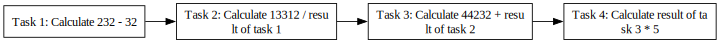

In [18]:
graph=display_graphviz('task6_graph.dot')
graph

![My Image](figures/Equation2.png)

In [19]:
task7="""

(((45 * 32 + 120) - 15**2) / 9) * (85 - ((12 + 5 * 7) / 4)) + 100 - (3**4 / 2) + ((500 / 25) * 6 - 200)
"""

In [20]:
plan = task_planner(task7)
# print(plan.model_dump_json(indent=2))
# print(Pretty(plan))
# Print JSON with rich syntax highlighting
json_str=plan.model_dump_json(indent=2)
# print(json_str)
syntax = Syntax(json_str, "json", theme="monokai", line_numbers=False)
print(syntax)

{                                                                                                                  
  "task_graph": [                                                                                                  
    {                                                                                                              
      "id": 1,                                                                                                     
      "task": "Calculate 45 * 32",                                                                                 
      "subtasks": []                                                                                               
    },                                                                                                             
    {                                                                                                              
      "id": 2,                                                                                                     
      "task": "Add 120 to the result of task 1",                                                                   
      "subtasks": [                                                                                                
        1                                                                                                          
      ]                                                                                                            
    },                                                                                                             
    {                                                                                                              
      "id": 3,                                                                                                     
      "task": "Calculate 15**2",                                                                                   
      "subtasks": []                                                                                               
    },                                                                                                             
    {                                                                                                              
      "id": 4,                                                                                                     
      "task": "Subtract the result of task 3 from the result of task 2",                                           
      "subtasks": [                                                                                                
        2,                                                                                                         
        3                                                                                                          
      ]                                                                                                            
    },                                                                                                             
    {                                                                                                              
      "id": 5,                                                                                                     
      "task": "Divide the result of task 4 by 9",                                                                  
      "subtasks": [                                                                                                
        4                                                                                                          
      ]                                                                                                            
    },                                                                                                             
    {                                                   

In [21]:

# Call the function to save the DOT file
save_dot_from_json(json_str,filename='task7_graph.dot')

DOT file saved as 'task7_graph.dot'.

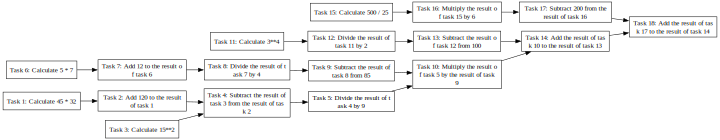

In [22]:
graph=display_graphviz('task7_graph.dot')
graph